# 7강 파이토치 워크플로우와 회귀 예측
## 이번 강의에서 다룰 내용
1. 데이터 준비하기 : 간단한 직선 형태의 데이터를 생성한다.
2. 모델 구축 : 데이터의 패턴을 학습하기 위해 모델을 만들고, 손실함수, 최적화 함수 등을 설정한다.
3. 모델 학습하기: 데이터와 모델이 있기때문에 모델이 데이터에서 패턴을 찾도록 한다.
4. 훈련된 모델로 예측 값 생성하기 : 학습한 모델을 사용해서 예측을 생성하는 방법 알아보자.
5. 모델 저장하고 불러오기 : 모델을 학습했으면 어딘가 가져다가 쓸 수 있어야겠죠. 모델을 저장하고 불러오는 방법을 알아보겠습니다.
5. 회귀 예측 수행해보기: 회귀 데이터 예제를 하나 가져와서 전체 워크플로우를 한번 실습해보겠다.

* 파이토치 워크플로우
![img](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png)

## 1. 데이터 준비하기
머신 러닝에서의 `데이터`는 거의 모든 것이 될 수 있다.
ex) 테이블 데이터, 이미지, 비디오, 노래와 같은 음성, 단백질 구조와 같은 시퀀스 데이터, 텍스트 등
머신 러닝 모델이 이러한 데이터를 학습하기 위해서 처음에 반드시 수행하는 것은 `데이터가 무엇이든 숫자(표현)로 바꾸는 것`입니다.

앞서 간단하게 1차원 방정식으로 회귀 모델을 만들었었는데요. 보다 많은 입력과 출력을 갖는 선형 회귀(직선) 데이터를 간단하게 만들어 보겠습니다.

6강에서 딥러닝 모델의 학습(파라미터 갱신)을 위해서 손실함수를 정의했고, 경사하강법을 사용하면 된다고 배웠습니다.
이번 강의에서는 이론시간에 배웠던 내용들이 실제 코드로 어떻게 구현되는지 확인해볼 겁니다.

In [1]:
import torch
from torch import nn #파이토치에서 모델을 만들때, 신경망 모델의 여러가지 미리 구현된 레이어를 가져다가 쓸 수 있는 패키지
import matplotlib.pyplot as plt #시각화를 위한 라이브러리

In [2]:
#알려진 매개변수(파라미터) 생성하기
weight = 0.5
bias = 0.1

# 임의의 직선 데이터 생성하기
start = 1
end = 2
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[1.0000],
         [1.0200],
         [1.0400],
         [1.0600],
         [1.0800],
         [1.1000],
         [1.1200],
         [1.1400],
         [1.1600],
         [1.1800]]), tensor([[0.6000],
         [0.6100],
         [0.6200],
         [0.6300],
         [0.6400],
         [0.6500],
         [0.6600],
         [0.6700],
         [0.6800],
         [0.6900]]))

### 훈련 데이터, 테스트 데이터 분할하기
우리는 모델 학습을 위해 훈련데이터와 테스트 데이터(필요한 경우 검증 데이터도)를 분할할 겁니다.
이 과정은 모델이 직접 보는 데이터와 보지 않는 데이터를 나누어 모델의 일반화 성능을 측정할 수 있기 때문에 매우 중요합니다.(제일 좋은 것은 분할하는 것이 아니고 애초에 따로 데이터가 존재해야 함)

만약 데이터가 따로 존재하지 않는 지금과 같은 상황에서는 일반적으로 

전체 데이터를 100%라고 보았을때,

* 훈련 데이터는 60~80%
* 검증 데이터는 10~20%
* 테스트 데이터는 10~20% 

의 비율로 분할 합니다.

이번 실습에서는 훈련, 테스트 데이터로만 분할할 겁니다.
다만, 이번 실습에서는 직접 크기를 지정해서 분할하지만 일반적으로 sklearn 라이브러리의 train_test_split이라는 함수를 사용합니다.
나중에 외부에서 데이터를 가져와서 학습할때 사용할테니 그때 어떻게 사용되는지 볼 수 있습니다.

In [3]:
# 훈련, 테스트 데이터 분할
train_split = int(0.8 * len(X)) # 80%를 훈련용, 20% 테스트용으로 분할하기 위한 비율 지정
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
#분할한 데이터의 각각의 크기 출력
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  
  plt.figure(figsize=(12, 9))

  # 분할 후 학습 데이터의 분포 확인 X,Y 값으로 뿌려줌
  plt.scatter(train_data, train_labels, c="b", s=4, label="Train data")
  
  # 분할 후 테스트 데이터의 분포 확인
  plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")

  if predictions is not None:
    # 예측 값들은 빨간색으로 표시할 것
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 18});

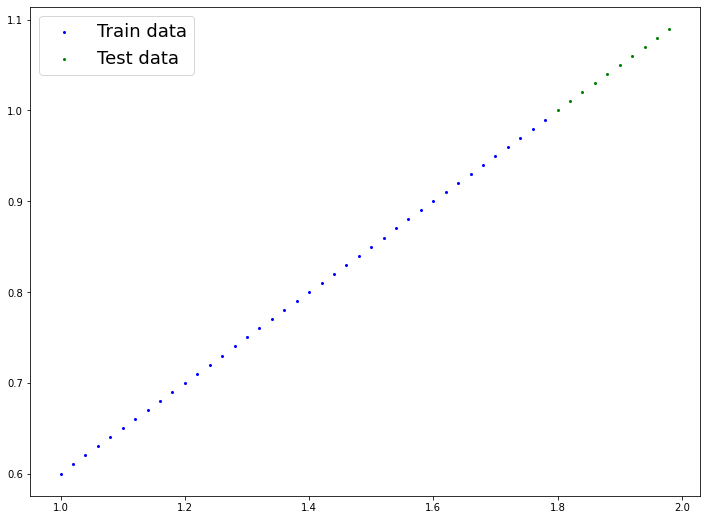

In [5]:
plot_predictions();

##2. 모델 구축

파이토치로 신경망을 만들때에는 정해진 구조가 있다.
```
class 모델이름(nn.Moldule):
  def __init__(self):
    super().init__()
    #사용할 레이어 종류와 입출력 크기 정의하기
    self.l1(input=10, output=20)
    self.l2(input=20, output=10)
    ...
  def forward(self, x): #x가 입력 받은 데이터를 말함 
    #입력 데이터 x를 가지고 어떠한 레이어를 거쳐 연산을 수행할지 순차적으로 나열함
    x2 = self.l1(x)
    output=self.l2(x2)
    return output
```

In [6]:
# 선형 회귀 모델 만들기
# 모델 정의 코드 블록
class LinearRegressionModel(nn.Module): # class 모델이름(nn.Module) 방식으로 사용함
    def __init__(self):
        super().__init__() # 고정된 모양
        self.weights = nn.Parameter(torch.randn(1, # <- 초기 값으로 랜덤한 숫자로 가중치 파라미터를 설정
            requires_grad=True, # 이후 현재 텐서의 그라디언트 계산을 추적하겠다는 표시
            dtype=torch.float # <- 기본으로 파이토치에서 float32를 사용하기에 별도 세팅이 필요없지만 보여주기 위해서 나타내었음
        ))

        self.bias = nn.Parameter(torch.randn(1, # 마찬가지로 bias(상수)의 초기값을 랜덤한 값으로 설정
            requires_grad=True,
            dtype=torch.float
        ))

    #실제로 모델의 계산이 이루어지는 부분 위에서는 사용할 레이어를 정의하고 커스터마이징 했을 뿐 실제 동작은 forward 부분에서 이루어짐
    def forward(self, x): # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### 모델 생성하고 정보 출력해보기

In [7]:
# 기존 수행했던 결과를 그대로 재현하기 위해 랜덤 초기화 시 고정 시드를 사용
# 기존에 생성되었던 랜덤 숫자 그대로 생성할 수 있도록 의도적으로 조정하는 것
torch.manual_seed(42)

#모델 생성하기
model = LinearRegressionModel()

#모델에 속한 파라미터 확인하기
list(model.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True), Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
#파라미터의 이름도 확인하기
model.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [9]:
# 모델의 예측 생성해보기
with torch.inference_mode(): 
    y_preds = model(X_test)

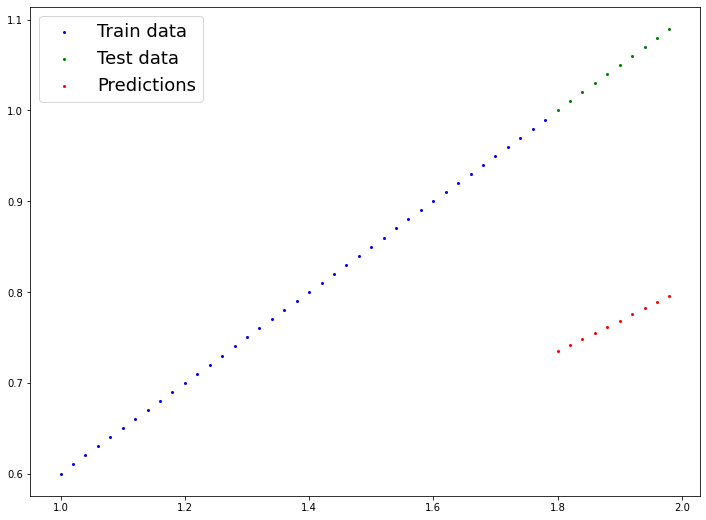

In [10]:
plot_predictions(predictions=y_preds)

초기 설정한 값으로 예측을 생성해보니 터무니 없이 예측을 생성한다는 것을 알았습니다.
그럼 

### 손실함수와 최적화 사용하기

In [11]:
#실제 값과 예측값의 차이 계산하기
y_test - y_preds

tensor([[0.2651],
        [0.2684],
        [0.2717],
        [0.2749],
        [0.2782],
        [0.2815],
        [0.2847],
        [0.2880],
        [0.2913],
        [0.2945]])

In [12]:
diff=y_test - y_preds
abs=torch.abs(diff)
abs

tensor([[0.2651],
        [0.2684],
        [0.2717],
        [0.2749],
        [0.2782],
        [0.2815],
        [0.2847],
        [0.2880],
        [0.2913],
        [0.2945]])

In [13]:
torch.mean(abs)

tensor(0.2798)

In [14]:
# 손실 함수 정의
loss_fn = nn.L1Loss() # Mean Absolute Error L1loss이다.

# 최적화 함수 정의
optimizer = torch.optim.SGD(params=model.parameters(), # 내가 사용한 모델의 파라미터를 최적화 하겠다.
                            lr=0.01) # 학습률을 사용자가 지정 얼마나 이동 하겠다.

##3. 모델 학습하기

In [15]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 100

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
test_losses = []
epoch_counts = []

# 설정한 epoch 수 만큼 반복
for epoch in range(epochs):

    # 모델에게 학습을 시작하겠다고 알림 그냥 이정표라고 생각하면 된다.
    model.train()

    # 원래 데이터를 구성하면 데이터 로더를 사용해서 학습하는데 
    # 우리가 직접 적은 양의 데이터를 만들었으니까 우선 그냥 사용하자.
    y_pred = model(X_train)

    # 예측 값과 실제 값을 모두 알고 있으니까 손실을 계산할 수 있다.
    loss = loss_fn(y_pred, y_train)

    # 최적화 함수 초기화 하기
    optimizer.zero_grad()

    # 역전파 수행하라는 명령
    loss.backward()

    # 파라미터를 최적화하라는 명령
    optimizer.step()

    # 테스트(검증)

    # 모델에 평가, 검증하겠다고 알림
    model.eval()

    with torch.inference_mode(): #그라디언트를 수정하지 않음
      # 테스트 데이터 X로 예측 값을 생성
      test_pred = model(X_test)

      # 테스트 데이터의 손실 계산
      test_loss = loss_fn(test_pred, y_test.type(torch.float))

      # 나머지 연산자를 이용해서 10번마다 획득한 손실 값들을 출력해준다.
      if epoch % 10 == 0:
            epoch_counts.append(epoch)
            train_losses.append(loss.detach().numpy())
            test_losses.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.19819101691246033 | MAE Test Loss: 0.24357476830482483 
Epoch: 10 | MAE Train Loss: 0.013273736461997032 | MAE Test Loss: 0.03077685832977295 
Epoch: 20 | MAE Train Loss: 0.011934816837310791 | MAE Test Loss: 0.02596094086766243 
Epoch: 30 | MAE Train Loss: 0.010601815767586231 | MAE Test Loss: 0.022986942902207375 
Epoch: 40 | MAE Train Loss: 0.0092803118750453 | MAE Test Loss: 0.02187374234199524 
Epoch: 50 | MAE Train Loss: 0.007938417606055737 | MAE Test Loss: 0.017076700925827026 
Epoch: 60 | MAE Train Loss: 0.0066015273332595825 | MAE Test Loss: 0.015982329845428467 
Epoch: 70 | MAE Train Loss: 0.01089412160217762 | MAE Test Loss: 0.03757665678858757 
Epoch: 80 | MAE Train Loss: 0.01089412160217762 | MAE Test Loss: 0.03757665678858757 
Epoch: 90 | MAE Train Loss: 0.01089412160217762 | MAE Test Loss: 0.03757665678858757 


### 결과 리포팅

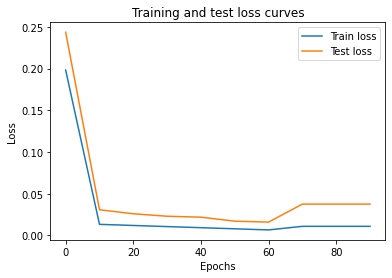

In [16]:
plt.plot(epoch_counts, train_losses, label="Train loss")
plt.plot(epoch_counts, test_losses, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [17]:
# 학습이 완료되었으니 파라미터가 어떻게 바뀌었는지 확인해봅시다.
print(model.state_dict())
print("\n 초기에 설정한 값은:",f"weights: {weight}, bias: {bias}였지요.")

OrderedDict([('weights', tensor([0.4756])), ('bias', tensor([0.1448]))])

 초기에 설정한 값은: weights: 0.5, bias: 0.1였지요.


##4. 훈련된 모델로 예측 값 생성하기

In [18]:
# 모델에 평가 모드로 전환했음을 알려주기
model.eval()

# 예측 생성 모드로 변경
with torch.inference_mode():
    y_preds = model(X_test)
y_preds
 

tensor([[1.0009],
        [1.0104],
        [1.0199],
        [1.0294],
        [1.0389],
        [1.0485],
        [1.0580],
        [1.0675],
        [1.0770],
        [1.0865]])

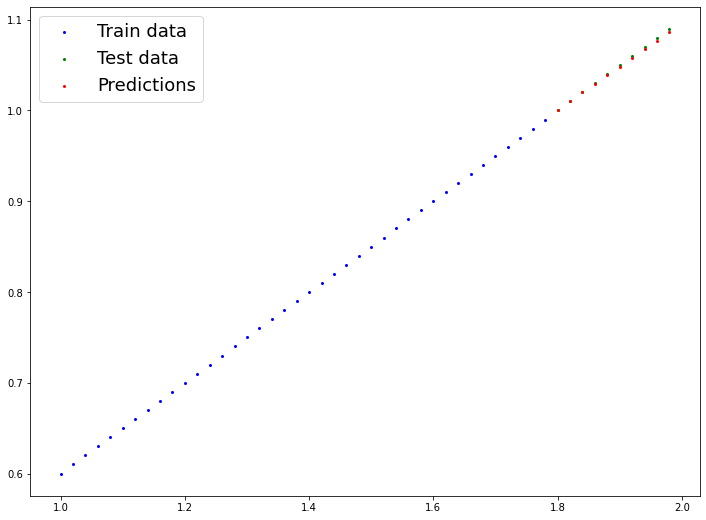

In [19]:
plot_predictions(predictions=y_preds)

##5. 모델 저장하고 불러오기
실제로 학습한 모델을 써먹기 위해서는 학습한 모델을 저장하고 다른 곳에서 불러올 수 있어야 된다.
* 모델의 저장에는 `torch.save()`를 쓰고 
* 모델을 불러오는데에는 `torch.load()`를 사용한다. 
* 또한 학습된 모델의 파라미터를 불러오는데에는 `load_state_dict()`을 사용한다.

### 모델 저장하기

In [20]:
from pathlib import Path

#모델을 저장하기위한 경로 설정 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

#모델을 해당 위치에 저장하기위한 경로, 이름 설정
MODEL_NAME = "pytorch_basic_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"모델 저장 위치와 파일명: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

모델 저장 위치와 파일명: models/pytorch_basic_model.pth


In [21]:
# 모델이 잘 저장되었는지 확인하기
!ls -l models/pytorch_basic_model.pth

-rw-r--r-- 1 root root 1063 Jul  7 06:41 models/pytorch_basic_model.pth


### 모델 불러오기

In [22]:
# 모델의 구조를 알도록 정의한 모델을 생성한다.
loaded_model = LinearRegressionModel()

# 다음 행에서 학습된 모델의 파라미터를 모델이 저장된 경로에서 불러온다.

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [23]:
# 불러온 모델이 잘 예측하는지 테스트 해보자.
loaded_model.eval()

# 모델 학습 과정에서 예측을 생성할때와 같이 불러온 모델로 예측 생성해보기
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

In [24]:
#학습된 모델의 예측 결과와 정말 동일한지 확인
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

##5. 회귀 예측 수행해보기

### 데이터의 형태 파악하기

In [25]:
!wget -q "http://deepchem.io.s3-website-us-west-1.amazonaws.com/datasets/Lipophilicity.csv" -O Lipophilicity.csv

In [59]:
import pandas as pd

data = pd.read_csv('Lipophilicity.csv')
data

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3


### SMILES 데이터를 사용해서 molecular fingerprint를 만듬


In [60]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np

In [62]:
fps = []
for i, smiles in enumerate(data["smiles"]):
    mol = Chem.MolFromSmiles(smiles)
    arr = np.zeros((1,))
    # rdkit의 fingerprint 함수를 사용해서 분자의 특성 수치화
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2048)
    DataStructs.ConvertToNumpyArray(fp, arr)
    
    fps.append(arr)
    
data["fp"] = fps
data

,CMPD_CHEMBLID,exp,smiles,fp
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
4195,CHEMBL496929,3.85,OCCc1ccc(NC(=O)c2cc3cc(Cl)ccc3[nH]2)cc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4196,CHEMBL199147,3.21,CCN(C1CCN(CCC(c2ccc(F)cc2)c3ccc(F)cc3)CC1)C(=O...,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4197,CHEMBL15932,2.10,COc1cccc2[nH]ncc12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4198,CHEMBL558748,2.65,Clc1ccc2ncccc2c1C(=O)NCC3CCCCC3,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### 훈련 데이터, 테스트 데이터 분할하기

In [64]:
from sklearn.model_selection import train_test_split

train_val, test = train_test_split(data, test_size=0.1, random_state=42)
train, val = train_test_split(train_val, test_size=0.1/0.9, random_state=42)

datasets = {
    "train": train,
    "val":  val,
    "test": test
}

datasets

{'test':       CMPD_CHEMBLID   exp                                             smiles  \
 1743  CHEMBL1431112  3.00      Clc1ccc2NC(=O)CN(C(c3ccccc3)c2c1)C(=O)c4occc4   
 2196  CHEMBL1322675  1.69             CCCNC[C@H](O)COc1ccccc1C(=O)CCc2ccccc2   
 1728  CHEMBL2030964  0.78  CNc1cccc(CCCc2ccc(C[C@H](NC(=O)c3c(Cl)cccc3Cl)...   
 3337  CHEMBL1381989  1.29                   CC1(C)CNC(=O)c2sc(nc2C1)N3CCOCC3   
 298     CHEMBL74582  3.07  C[C@@](O)(C(=O)Nc1ccc(cc1Cl)S(=O)(=O)NCC=C)C(F...   
 ...             ...   ...                                                ...   
 3949   CHEMBL203059  3.70        O=C(Nc1cc(ccn1)c2ccnc(Nc3ccccc3)c2)C4CCOCC4   
 174   CHEMBL2181927  2.51  CCOc1ncc(C)c2NC(=C([C@@H](c3ccc(cc3OC)C#N)c12)...   
 393   CHEMBL1721498  2.72              Clc1ccc(cc1)C(=O)C2CCN(CC2)C(=O)C3CC3   
 3721  CHEMBL2158838  2.86  OC(=O)[C@H](Cc1ccc(Cl)cc1)N2CCC(CN3CCC(CC3)Oc4...   
 3713   CHEMBL335749  3.02  CC(=O)NC[C@H]1CN(C(=O)O1)c2ccc(N3Cc4ccncc4C3)c...   
 
                  

### 커스텀 데이터세트 만들기

In [79]:
from torch.utils.data import Dataset

class LipoDataset(Dataset):
    
    def __init__(self, df):
        self.x = list(df["fp"])
        self.y = list(df["exp"].values)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        return torch.tensor(self.x[index]).float(),  torch.tensor(self.y[index]).float()
    
lipodata = {
    "train": LipoDataset(datasets["train"]),
    "val": LipoDataset(datasets["val"]),
    "test": LipoDataset(datasets["test"]),
}

lipodata

{'test': <__main__.LipoDataset at 0x7fe2a879a310>,
 'train': <__main__.LipoDataset at 0x7fe2a879a650>,
 'val': <__main__.LipoDataset at 0x7fe2a89a6e90>}

### MLP 모델 만들기

In [80]:
import torch.nn as nn

class MLP(nn.Module):
    
    def __init__(self):
        super(MLP, self).__init__()
        
        self.linear1 = nn.Linear(2048, 1024) # 완전 연결된 단순 레이어 만들기 
        self.linear2 = nn.Linear(1024, 256)
        self.output = nn.Linear(256, 1) # 최종 예측을 위해 출력 부 크기 1로 설정 
        self.dropout1 = nn.Dropout(0.5) #일반화를 위한 Dropout
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.dropout1(out)
        out = self.relu(out)
        out = self.output(out)
        return out
        
model = MLP()
model

MLP(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

### 모델 GPU에 올리기

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [82]:
model.to(device)

MLP(
  (linear1): Linear(in_features=2048, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

### 데이터 로더 만들기
파이토치에서 `DataLoader`는 파이토치 학습에 유용한 데이터 조작 도구인데, 데이터 로더에 배치크기(1번에 입력으로 줄 단위)를 정해줄 수 있어 별도의 데이터 배치 크기 조절이 필요 없다는 장점이 있다.

In [83]:
from torch.utils.data import DataLoader

dataloaders = {
    "train": DataLoader(lipodata["train"], batch_size=32, shuffle=True),
    "val": DataLoader(lipodata["val"], batch_size=32, shuffle=False),
    "test": DataLoader(lipodata["test"], batch_size=32, shuffle=False)
}

dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7fe2a878f450>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7fe2a878f7d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7fe2a878f990>}

In [84]:
for data in dataloaders["train"]:
    x, y = data
    print(x.shape, y.shape)

torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])
torch.Size([32, 2048]) torch.Size([32])


### 모델 학습하기

In [85]:
#최적화 함수 정의
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [95]:
torch.manual_seed(42)

# 전체 학습 데이터로 몇번 학습 시킬 것이냐를 결정
epochs = 51

# 손실 값을 저장하기 위한 변수 정의
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for i, data in enumerate(dataloaders["train"]):
        x, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(x)
        train_loss = loss_fn(outputs, y.view(-1, 1))
        train_loss.backward()
        optimizer.step()
        
        epoch_train_loss += train_loss.item()
        
    model.eval()
    epoch_val_loss = 0.0
    with torch.inference_mode():
        for i, data in enumerate(dataloaders["val"]):
            x, y = data[0].to(device), data[1].to(device)
                        
            outputs = model(x)
            val_loss = loss_fn(outputs, y.view(-1, 1))
            epoch_val_loss += val_loss.item()
            
    epoch_train_loss /= len(dataloaders["train"])
    epoch_val_loss /= len(dataloaders["val"])
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    if epoch % 10 == 0:
        print("[Epoch %d] Train Loss: %.3f  Validation Loss: %.3f" %
              (epoch, epoch_train_loss, epoch_val_loss))

[Epoch 0] Train Loss: 1.059  Validation Loss: 0.884
[Epoch 10] Train Loss: 1.064  Validation Loss: 0.947
[Epoch 20] Train Loss: 1.069  Validation Loss: 0.956
[Epoch 30] Train Loss: 1.014  Validation Loss: 0.858
[Epoch 40] Train Loss: 1.174  Validation Loss: 1.063
[Epoch 50] Train Loss: 1.128  Validation Loss: 0.985


### 결과 리포팅하기

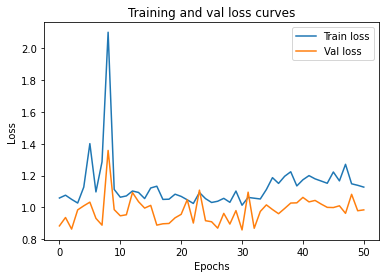

In [96]:
epoch_count = range(epochs)
plt.plot(epoch_count, train_losses, label="Train loss")
plt.plot(epoch_count, val_losses, label="Val loss")
plt.title("Training and val loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

### 훈련된 모델로 예측 값 생성하기

In [98]:
from sklearn.metrics import mean_absolute_error

model.eval()
mae = 0.0
predictions = []
truths = []
with torch.inference_mode():
    for data in dataloaders["test"]:
        x, y = data[0].to(device), data[1].to(device)
        outputs = model(x)
        
        #리스트에 반복학습해서 생성되는 레이블과 예측 값 넣어주기
        labels = y.cpu().detach().numpy().tolist()
        preds = [output[0] for output in outputs.cpu().detach().numpy().tolist()]
        
        truths += labels
        predictions += preds
        
        mae += mean_absolute_error(labels, preds)
    
    mae /= len(dataloaders["test"])
mae

0.7958115023918383